# Задание 3

Седых Иван Дмитриевич БПМ181

In [1]:
import math

import numpy as np
import sympy as sym
from scipy import odr
from matplotlib import pyplot as plt
import tqdm
import seaborn as sns
from plotly import graph_objects as go


np.set_printoptions(suppress=True)
plt.style.use('ggplot')

---
## Task 3

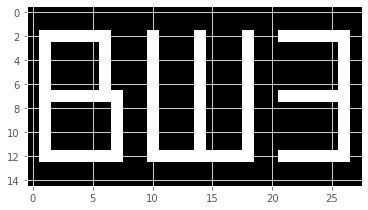

In [2]:
a = np . zeros ((15 , 28))
a [2: -2 ,1] = 1; a [2 ,2:6] = 1
a [2:7 ,6] = 1; a [7: -2 ,7] = 1
a [7 ,2:7] = 1; a [ -3 ,2:7] = 1
a [2: -2 , 10] = 1; a [2: -2 , 14] = 1;
a [2: -2 , 18] = 1; a [ -3 ,10:19] = 1

# add letter Э
a[2: -2, -2] = 1
a[2, 21 : -2] = 1
a[7, 21 : -2] = 1
a[-3, 21 : -2] = 1

plt.imshow(a, cmap='gray');

In [3]:
r = np.linalg.matrix_rank(a)
print(f"rank(a) = {r}")

rank(a) = 5


По теореме Эккарта-Янга, наилучшее малоранговое приближение матрицы (в норме Фробениуса и спектарльной) получается путем обнуления последних нескольких сингулярных чисел в SVD разложении.

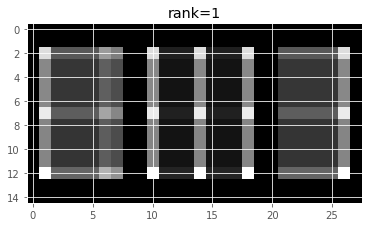

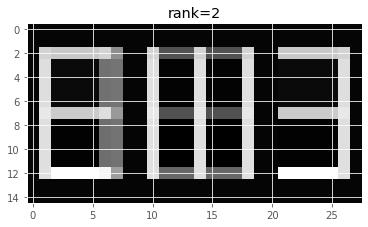

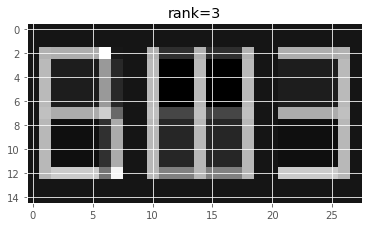

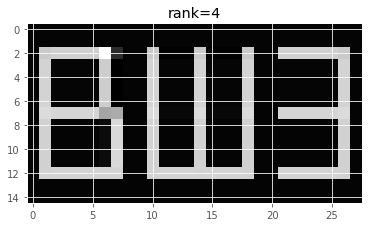

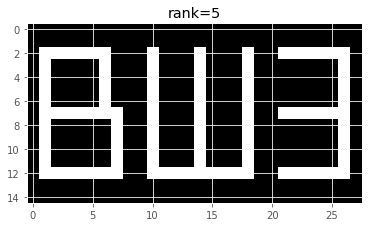

In [13]:
U, s, V = np.linalg.svd(a, full_matrices=False)
for i in range(1, r + 1):
    s_trunc = s.copy()
    s_trunc[i:] = 0
    B = U * s_trunc @ V
    assert np.linalg.matrix_rank(B) == i
    plt.title(f'rank={i}')
    plt.imshow(B, cmap='gray')
    plt.show()

---
## Task 4

На приложенном фото я показал, что координата $x(10) = \sum_{i=1}^{10} (10.5-i)f_i$.  
Очевидно, что скорость $v(10) = \sum_{i=1}^{10}f_i$.  
То есть первая строка матрицы $A$ задается, как $a_{1i} = 10.5-i$, а вторая строка состоит из единиц $a_{2i} = 1$.

Знаем, что выполняется
$$
Af = a
$$
где $a = (x(10), v(10))$

Теперь найдем решение на $f$ минимальной нормы при заданном $a$.  
Наша система является недоопределенной и имеет бесконечно много решений, поэтому сформулируем задачу в теримнах метода множителей Лагранжа.
$$
L(f, \lambda) = f^Tf + \lambda^T (Af - a)
$$
$$
\begin{cases}
\nabla_f L = 2f + A^T\lambda = 0 \\ 
\nabla_{\lambda} L = Af - a = 0 
\end{cases}
$$
Осталось присто решить эту систему.
$$
f = -\frac{1}{2} A^T \lambda \\
Af = -\frac{1}{2} AA^T \lambda = a \implies \lambda = -2 (AA^T)^{-1} a \\
2f + A^T (-2 (AA^T)^{-1} a) = 0
$$
В итоге получим
$$
f^* = A^T (AA^T)^{-1} a
$$
Причем $A^T (AA^T)^{-1} = A^{\dagger}$ - это так называемая **левая** псевдообратная матрица.  
Если разложить $A = U \Sigma V^T$ и подставить в $A^{\dagger}$, то получим  
$$
A^{\dagger} = V \Sigma^T(\Sigma \Sigma^T)^{-1} U
$$
Причем зная диагональную структуру $\Sigma$, можем сказать что $\Sigma^T(\Sigma \Sigma^T)^{-1}$ - это матрица $2 \times 10$, у которой на главной диагонали стоят обратные сингулярные числа.

In [71]:
# set A
A = np.ones((2, 10))
A[0] = np.array([10.5 - i for i in range(1, 11)])
A[1] = 1
# set a
a = np.array([1, 0])
print("A", A, a)

U, s, V = np.linalg.svd(A)
S_inv = np.zeros((10, 2))
np.fill_diagonal(S_inv, 1 / s)

# because svd returns transposed V
f = V.T @ S_inv @ U.T @ a
assert np.allclose(A@f, a)

print(f"Найденный вектор:\n{f}")
print(f"Его норма:\n{np.linalg.norm(f):.3f}")

A [[9.5 8.5 7.5 6.5 5.5 4.5 3.5 2.5 1.5 0.5]
 [1.  1.  1.  1.  1.  1.  1.  1.  1.  1. ]] [1 0]
Найденный вектор:
[ 0.05454545  0.04242424  0.03030303  0.01818182  0.00606061 -0.00606061
 -0.01818182 -0.03030303 -0.04242424 -0.05454545]
Его норма:
0.110


---
## Task 5 (Возмущение корреляционной матрицы)

In [5]:
C = np.array([
    [1, 0.9, 0.7],
    [0.9, 1, 0.4],
    [0.7, 0.4, 1],
    ])
print("Eigenvals before adjacment:")
print(np.linalg.eigvals(C))

Eigenvals before adjacment:
[2.35363603 0.03034736 0.6160166 ]


In [6]:
C_0 = C.copy()
C_0[[[1, 2], [2, 1]]] = 0.3
print("Eigenvals after adjacment:")
print(np.linalg.eigvals(C_0))

Eigenvals after adjacment:
[ 2.29672779 -0.00735244  0.71062465]


### (a)

In [7]:
lam, s = np.linalg.eig(C_0)
lam[lam < 0] = 0
lam, s

(array([2.29672779, 0.        , 0.71062465]),
 array([[ 0.65991684,  0.74767038, -0.0741536 ],
        [ 0.57099598, -0.5632171 , -0.5972856 ],
        [ 0.48833733, -0.35181742,  0.79859323]]))

### (b)

Нужно умножать не на $\lambda_i$, а на $\sqrt{\lambda_i}$.  
Это не я придумал, это написано в книге, откуда взят метод.

In [8]:
B_dash = np.sqrt(lam) * s
B_dash

array([[ 1.00010127,  0.        , -0.06251041],
       [ 0.86534206, -0.        , -0.50350313],
       [ 0.74007321, -0.        ,  0.67320256]])

### (c)

In [9]:
B = 1. / np.linalg.norm(B_dash, axis=1)[:, None] * B_dash
B

array([[ 0.99805232,  0.        , -0.06238235],
       [ 0.86433471, -0.        , -0.502917  ],
       [ 0.73973669, -0.        ,  0.67289645]])

In [10]:
np.linalg.norm(B, axis=1)

array([1., 1., 1.])

### (d)

In [11]:
C_1 = B @ B.T
C_1

array([[1.        , 0.89402441, 0.69631907],
       [0.89402441, 1.        , 0.30096904],
       [0.69631907, 0.30096904, 1.        ]])